In [2]:
from itertools import chain
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

In [6]:
import numpy as np

In [3]:
datapath = Path('..', 'data')

In [9]:
with open(datapath / 'dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
with open(datapath / 'cuisine.pkl', 'rb') as f:
    cuisine = pickle.load(f)

with open(datapath / 'ingredient.pkl', 'rb') as f:
    ingredient = pickle.load(f)

In [7]:
cuisine.requires_grad = False
ingredient.requires_grad = False

np_cui = np.array(cuisine)
np_ing = np.array(ingredient)

In [123]:
encoder = MultiLabelBinarizer()
encoder.fit([range(len(dataset['ingredient_codes']))])
y_train = dataset['y_train']
y_val = dataset['y_cls_val']

In [124]:
X_train = []
X_val = []

for data in dataset['X_train']:
    dd = []
    for ing in data:
        dd.append(np_ing[ing])
    X_train.append(np.array(dd).mean(axis = 0))
    
for data in dataset['X_cls_val']:
    dd = []
    for ing in data:
        dd.append(np_ing[ing])
    X_val.append(np.array(dd).mean(axis = 0))

In [125]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [126]:
classifier = RandomForestClassifier(n_estimators=200, n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

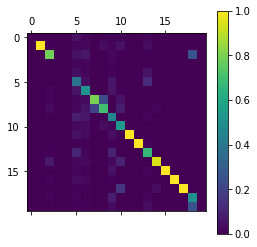

In [127]:
confusion = confusion_matrix(y_val, y_pred, normalize='pred')
plt.matshow(confusion, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [128]:
accuracy_score(y_val, y_pred), precision_score(y_val, y_pred, average='weighted')

/mnt/daeho715/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4738786952089704, 0.5661673397346232)

In [71]:
classifier = LogisticRegression(C=1, max_iter=1000, n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

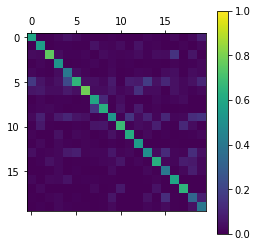

In [72]:
confusion = confusion_matrix(y_val, y_pred, normalize='pred')
plt.matshow(confusion, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [73]:
accuracy_score(y_val, y_pred), precision_score(y_val, y_pred, average='weighted')

(0.6379969418960245, 0.6278895642349006)

In [82]:
classifier = LinearSVC(C=0.3, max_iter=10000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

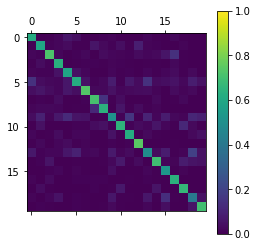

In [83]:
confusion = confusion_matrix(y_val, y_pred, normalize='pred')
plt.matshow(confusion, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [84]:
accuracy_score(y_val, y_pred), precision_score(y_val, y_pred, average='weighted')

(0.634683995922528, 0.6292616950867742)

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [86]:
device = torch.device('cuda')

In [87]:
savepath = Path('..', 'save')
savepath.mkdir(exist_ok=True)

In [115]:
class Net(nn.Module):
    def __init__(self, in_feats, out_feats, p_dropout):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p_dropout),
            nn.Linear(in_feats, 512),
            nn.Dropout(p_dropout),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(512, out_feats),
        )

    def forward(self, X):
        logits = self.linear_relu_stack(X)
        return logits

In [116]:
dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float, device=device),
    torch.tensor(y_train, dtype=torch.long, device=device),
), shuffle=True, batch_size=8)
valloader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float, device=device),
    torch.tensor(y_val, dtype=torch.long, device=device),
), batch_size=64)

In [117]:
net = Net(
    256,
    len(dataset['cuisine_codes']),
    p_dropout=0.5
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [118]:
best_val_loss = float('inf')

for epoch in range(20, 40):
    train_loss = 0
    val_loss = 0

    net.train()
    for X, y in dataloader:
        y_prob = net(X)
        loss = F.cross_entropy(y_prob, y)

        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        for X, y in valloader:
            y_prob = net(X)
            loss = F.cross_entropy(y_prob, y)

            val_loss += loss

    train_loss /= len(dataloader)
    val_loss /= len(valloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), savepath / f'_300_300_{epoch}.pt')

    print(f'Epoch {epoch} | Train loss: {train_loss} | Val loss: {val_loss}', flush=True)

Epoch 20 | Train loss: 2.0021417140960693 | Val loss: 1.5599676370620728
Epoch 21 | Train loss: 1.7868720293045044 | Val loss: 1.4763295650482178
Epoch 22 | Train loss: 1.7597464323043823 | Val loss: 1.4333062171936035
Epoch 23 | Train loss: 1.742803692817688 | Val loss: 1.4215929508209229
Epoch 24 | Train loss: 1.735541820526123 | Val loss: 1.4196341037750244
Epoch 25 | Train loss: 1.7193516492843628 | Val loss: 1.4243113994598389
Epoch 26 | Train loss: 1.71531081199646 | Val loss: 1.4117982387542725
Epoch 27 | Train loss: 1.7116334438323975 | Val loss: 1.3981068134307861
Epoch 28 | Train loss: 1.7067480087280273 | Val loss: 1.40183424949646
Epoch 29 | Train loss: 1.6887363195419312 | Val loss: 1.3919910192489624
Epoch 30 | Train loss: 1.7096072435379028 | Val loss: 1.3963133096694946
Epoch 31 | Train loss: 1.698947787284851 | Val loss: 1.4007561206817627
Epoch 32 | Train loss: 1.6847940683364868 | Val loss: 1.408172607421875
Epoch 33 | Train loss: 1.6830495595932007 | Val loss: 1.396

In [97]:
net.load_state_dict(torch.load(savepath / '_300_300_16.pt'))
net.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../save/_300_300_16.pt'

In [119]:
y_logits = net(torch.tensor(X_val_m, dtype=torch.float, device=device))
y_pred = torch.argmax(y_logits, dim=-1).detach().cpu().numpy()

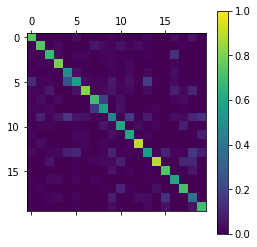

In [120]:
confusion = confusion_matrix(y_val, y_pred, normalize='pred')
plt.matshow(confusion, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [121]:
accuracy_score(y_val, y_pred), precision_score(y_val, y_pred, average='weighted')

(0.6160805300713558, 0.6374818477973658)